In [1]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt
from easydict import EasyDict
import seaborn as sns
import re
import copy

sns.set(style="whitegrid")
sns.set_context("paper")

# Function to read tensorboard_data from TensorBoard logs
def read_data(main_dir):
    all_data = {}

    for subdir in os.listdir(main_dir):
        log_dir = os.path.join(main_dir, subdir)
        if os.path.isdir(log_dir):
            event_acc = EventAccumulator(log_dir)
            event_acc.Reload()

            tag = 'charts/episodic_return'
            events = event_acc.Scalars(tag)

            data = pd.DataFrame([(e.wall_time, e.step, e.value) for e in events], 
                                columns=['Wall time', 'Step', 'Value'])
            data = data.sort_values('Step')

            all_data[subdir] = data

    return EasyDict(all_data)

# Function to filter dictionary values by key pattern
def filter_dict_values_by_key_pattern(input_dict, pattern):
    regex = re.compile(pattern)
    return [value for key, value in input_dict.items() if regex.match(key)]

# Function to preprocess and combine dataframes
def list_process_fun(dfs, max_value):
    def preprocess_df(df):
        df.drop('Wall time', axis=1, inplace=True)
        step_interval = int(max_value / 100)
        df['Step Group'] = (df['Step'] // step_interval) * step_interval + step_interval
        df['Step'] = df['Step Group']
        return df.drop('Step Group', axis=1)

    combined_df = pd.concat([preprocess_df(df) for df in dfs], ignore_index=True)
    grouped = combined_df.groupby('Step')['Value'].agg(['mean', 'std'])
    return combined_df.merge(grouped, on='Step', how='left')

In [2]:
# Load tensorboard_data from directories
CartPole_data = read_data('tensorboard_data/discrete/env_CartPole-v1')
MountainCar_data = read_data('tensorboard_data/discrete/env_MountainCar-v0')
Acrobot_data = read_data('tensorboard_data/discrete/env_Acrobot-v1')
LunarLander_data = read_data('tensorboard_data/discrete/env_LunarLander-v2')
Pendulum_data = read_data('tensorboard_data/continue/env_Pendulum-v1')
MountainCarContinuous_data = read_data('tensorboard_data/continue/env_MountainCarContinuous-v0')
BipedalWalker_data = read_data('tensorboard_data/continue/env_BipedalWalker-v3')
LunarLanderC_data = read_data('tensorboard_data/continue/env_LunarLander-v2')

# Patterns for filtering tensorboard_data
pattern_ORI = r'^ORI_seed_\d{2}_PPO$'
pattern_CartPole = r'^QUANTUM_NOTNN_4P_INN_seed_\d{2}_Q_PPO_n_blocks_1$'
pattern_MountainCar = r'^QUANTUM_NOTNN_2P_INN_seed_\d{2}_Q_PPO_n_blocks_3$'
pattern_Acrobot = r'^QUANTUM_INN_4P_XNN_seed_\d{2}_Q_PPO_n_blocks_1$'
pattern_LunarLander = r'^QUANTUM_XNN_4P_INN_seed_\d{2}_Q_PPO_n_blocks_1$'
pattern_Pendulum = r'^QUANTUM_NOTNN_3P_XNN_seed_\d{2}_Q_PPO_n_blocks_2$'
pattern_MountainCarContinuous = r'^QUANTUM_NOTNN_2P_XNN_seed_\d{2}_Q_PPO_n_blocks_3$'
pattern_BipedalWalker_1 = r'^QUANTUM_ONN_4P_ONN_seed_\d{2}_Q_PPO_n_blocks_1$'
pattern_LunarLander_C_2 = r'^QUANTUM_INN_4P_ONN_seed_\d{2}_Q_PPO_n_blocks_1$'

# Filter and preprocess tensorboard_data
CartPole_ORI = list_process_fun(filter_dict_values_by_key_pattern(CartPole_data, pattern_ORI), 1e5)
MountainCar_ORI = list_process_fun(filter_dict_values_by_key_pattern(MountainCar_data, pattern_ORI), 1e6)
Acrobot_ORI = list_process_fun(filter_dict_values_by_key_pattern(Acrobot_data, pattern_ORI), 1e6)
LunarLander_ORI = list_process_fun(filter_dict_values_by_key_pattern(LunarLander_data, pattern_ORI), 1e6)
Pendulum_ORI = list_process_fun(filter_dict_values_by_key_pattern(Pendulum_data, pattern_ORI), 1e5)
MountainCarContinuous_ORI = list_process_fun(filter_dict_values_by_key_pattern(MountainCarContinuous_data, pattern_ORI), 20000)
BipedalWalker_ORI = list_process_fun(filter_dict_values_by_key_pattern(BipedalWalker_data, pattern_ORI), 4e6)
LunarLanderC_ORI = list_process_fun(filter_dict_values_by_key_pattern(LunarLanderC_data, pattern_ORI), 1.75e6)

CartPole_NQ = list_process_fun(filter_dict_values_by_key_pattern(CartPole_data, pattern_CartPole), 1e5)
MountainCar_NQ = list_process_fun(filter_dict_values_by_key_pattern(MountainCar_data, pattern_MountainCar), 1e6)
Acrobot_NQ = list_process_fun(filter_dict_values_by_key_pattern(Acrobot_data, pattern_Acrobot), 1e6)
LunarLander_NQ = list_process_fun(filter_dict_values_by_key_pattern(LunarLander_data, pattern_LunarLander), 1e6)
Pendulum_NQ = list_process_fun(filter_dict_values_by_key_pattern(Pendulum_data, pattern_Pendulum), 1e5)
MountainCarContinuous_NQ = list_process_fun(filter_dict_values_by_key_pattern(MountainCarContinuous_data, pattern_MountainCarContinuous), 20000)
BipedalWalker_NQ1 = list_process_fun(filter_dict_values_by_key_pattern(BipedalWalker_data, pattern_BipedalWalker_1), 4e6)
LunarLanderC_NQ2 = list_process_fun(filter_dict_values_by_key_pattern(LunarLanderC_data, pattern_LunarLander_C_2), 1.75e6)

# Add condition labels
for df, condition in [(CartPole_ORI, 'Classical NNs'), (MountainCar_ORI, 'Classical NNs'),
                      (Acrobot_ORI, 'Classical NNs'), (LunarLander_ORI, 'Classical NNs'),
                      (Pendulum_ORI, 'Classical NNs'), (MountainCarContinuous_ORI, 'Classical NNs'),
                      (BipedalWalker_ORI, 'Classical NNs'), (LunarLanderC_ORI, 'Classical NNs'),
                      (CartPole_NQ, 'Hybrid Quantum Actor'), (MountainCar_NQ, 'Hybrid Quantum Actor'),
                      (Acrobot_NQ, 'Hybrid Quantum Actor'), (LunarLander_NQ, 'Hybrid Quantum Actor'),
                      (Pendulum_NQ, 'Hybrid Quantum Actor'), (MountainCarContinuous_NQ, 'Hybrid Quantum Actor'),
                      (BipedalWalker_NQ1, 'Hybrid Quantum Actor'), (LunarLanderC_NQ2, 'Hybrid Quantum Actor')]:
    df['Condition'] = condition

# Combine datasets
CartPole_combined_df = pd.concat([CartPole_ORI, CartPole_NQ], ignore_index=True)
MountainCar_combined_df = pd.concat([MountainCar_ORI, MountainCar_NQ], ignore_index=True)
Acrobot_combined_df = pd.concat([Acrobot_ORI, Acrobot_NQ], ignore_index=True)
LunarLander_combined_df = pd.concat([LunarLander_ORI, LunarLander_NQ], ignore_index=True)
Pendulum_combined_df = pd.concat([Pendulum_ORI, Pendulum_NQ], ignore_index=True)
MountainCarContinuous_combined_df = pd.concat([MountainCarContinuous_ORI, MountainCarContinuous_NQ], ignore_index=True)
BipedalWalker_combined_df = pd.concat([BipedalWalker_ORI, BipedalWalker_NQ1], ignore_index=True)
LunarLanderC_combined_df = pd.concat([LunarLanderC_ORI, LunarLanderC_NQ2], ignore_index=True)

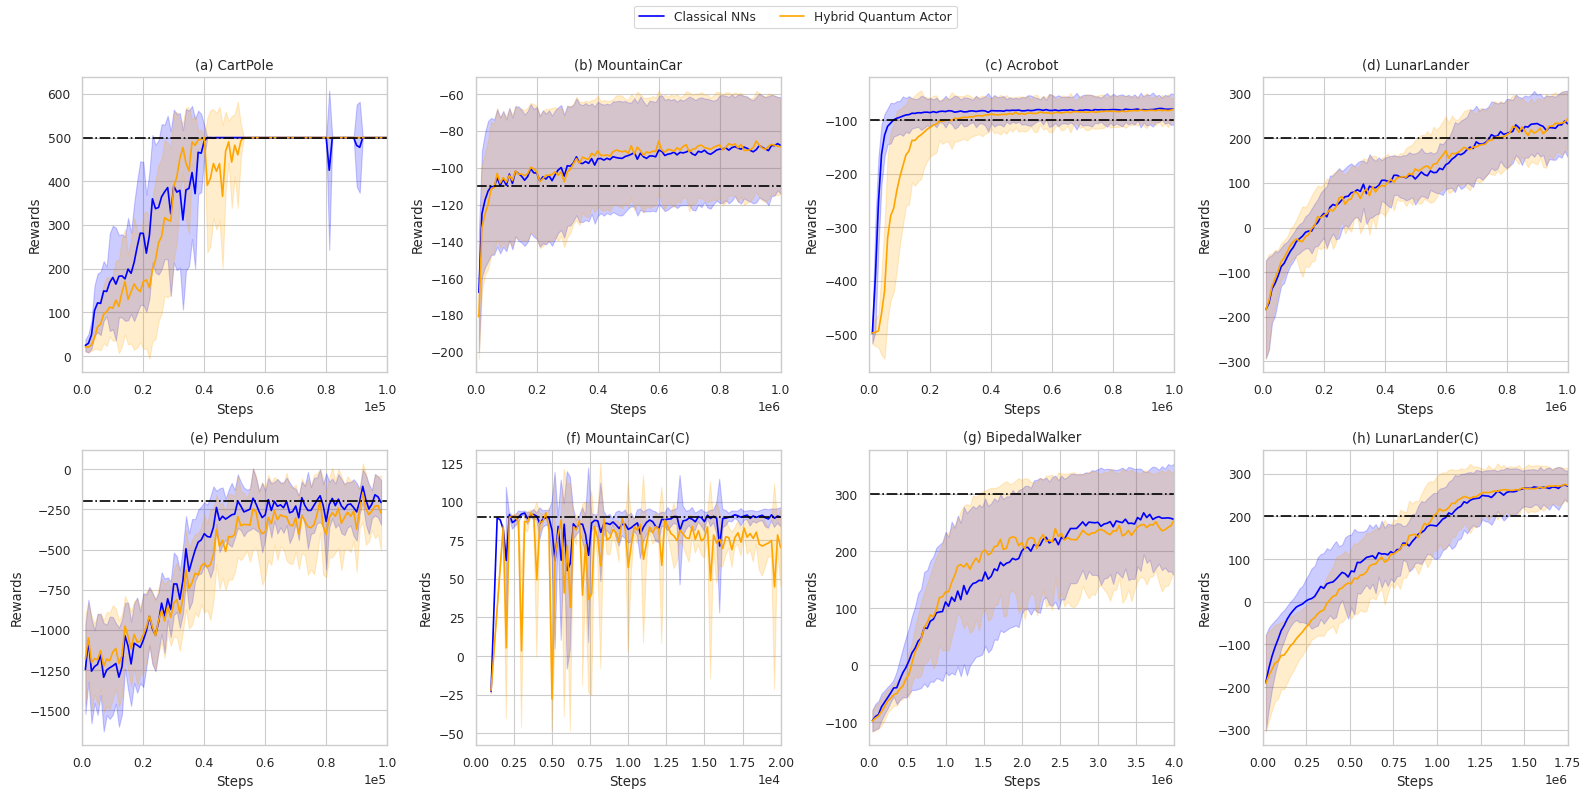

In [3]:
# Plot results
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
color_mapping = {'Classical NNs': 'blue', 'Hybrid Quantum Actor': 'orange'}

def plot_subplot(ax, data, title, xlim, hline):
    sns.lineplot(x='Step', y='Value', hue='Condition', data=data,
                 palette=color_mapping, ax=ax, err_style='band', errorbar='sd')
    ax.set_xlim(0, xlim)
    ax.axhline(hline, color='black', linewidth=1.2, linestyle='-.')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    ax.set_title(title)
    ax.set_xlabel('Steps')
    ax.set_ylabel('Rewards')
    ax.get_legend().remove()

plot_subplot(axs[0, 0], CartPole_combined_df, '(a) CartPole', 1e5, 500)
plot_subplot(axs[0, 1], MountainCar_combined_df, '(b) MountainCar', 1e6, -110)
plot_subplot(axs[0, 2], Acrobot_combined_df, '(c) Acrobot', 1e6, -100)
plot_subplot(axs[0, 3], LunarLander_combined_df, '(d) LunarLander', 1e6, 200)
plot_subplot(axs[1, 0], Pendulum_combined_df, '(e) Pendulum', 1e5, -200)
plot_subplot(axs[1, 1], MountainCarContinuous_combined_df, '(f) MountainCar(C)', 20000, 90)
plot_subplot(axs[1, 2], BipedalWalker_combined_df, '(g) BipedalWalker', 4e6, 300)
plot_subplot(axs[1, 3], LunarLanderC_combined_df, '(h) LunarLander(C)', 1.75e6, 200)

handles, labels = axs[1, 2].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('./fig_results.pdf', dpi=600)
plt.show()
